In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse, mape
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
import statsmodels

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of 2015 for the case study

In [17]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_CA_3_2014.csv',index_col='date').fillna(0)[:-1]
data.index = data.index.astype('datetime64[ns]')
data = data.loc['2014-01-01':'2016-05-01']

data.reset_index(inplace=True)

In [18]:
#modify wday into sin and cos to get rid if hierarchy in the cat numbers

#data['sin_wday'] = data.wday.apply(math.sin)
#data['cos_wday'] = data.wday.apply(math.cos)

# transfor unique event days into bool, as we only use data for 1 year, so they won't repeat anyway
data['event_1'] = data.event_name_1.map({0:0}).fillna(1)
data['event_2'] = data.event_name_2.map({0:0}).fillna(1)

# still want to know the type though

data = data.join(pd.get_dummies(data.event_type_1, prefix='event_type_1'))
data = data.join(pd.get_dummies(data.event_type_2, prefix='event_type_2'))

# getting rid of irrelevant data

data = data.drop(['d','store_id','weekday','wday',
                  'event_name_1', 'event_name_2',
                  'event_type_1','event_type_2',
                  'year','snap_TX','snap_WI'], axis=1)

weekly_sale_price = pd.DataFrame(data.groupby('item_id').resample('W-Mon', on='date').mean()['sell_price'])
data = data.groupby('item_id').resample('W-Mon', on='date').sum()
data['sale_price'] = weekly_sale_price['sell_price']

data.reset_index(inplace=True)

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [19]:
top_items = data.groupby('item_id').sum().sort_values(by='sales').index[-5:]

alt.data_transformers.disable_max_rows()

alt.Chart(data.loc[data.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [20]:
top_items

Index(['HOUSEHOLD_1_110', 'HOUSEHOLD_1_465', 'HOUSEHOLD_1_118',
       'HOUSEHOLD_1_459', 'HOBBIES_1_234'],
      dtype='object', name='item_id')

In [21]:
def get_input_item(item_id='HOBBIES_1_234'):
    item = data.loc[data.item_id.isin([item_id])]
    return item

len(get_input_item(item_id='HOBBIES_1_234'))

122

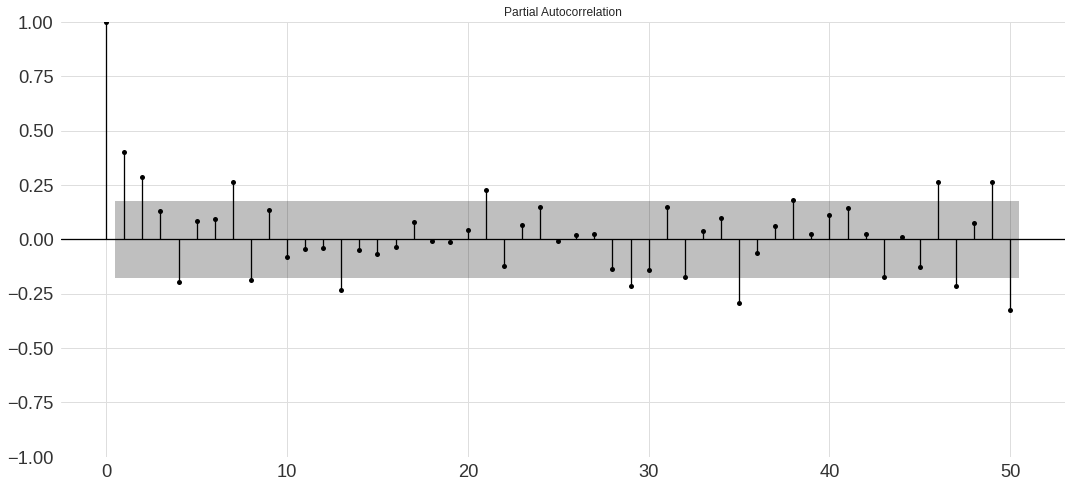

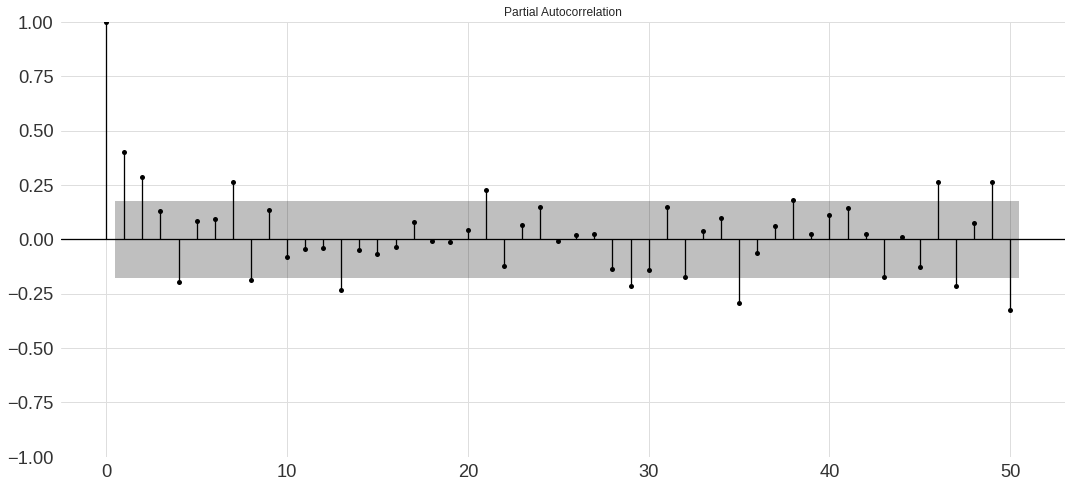

In [26]:
sm.graphics.tsa.plot_pacf(get_input_item(item_id='HOUSEHOLD_1_465').sales,lags=50)

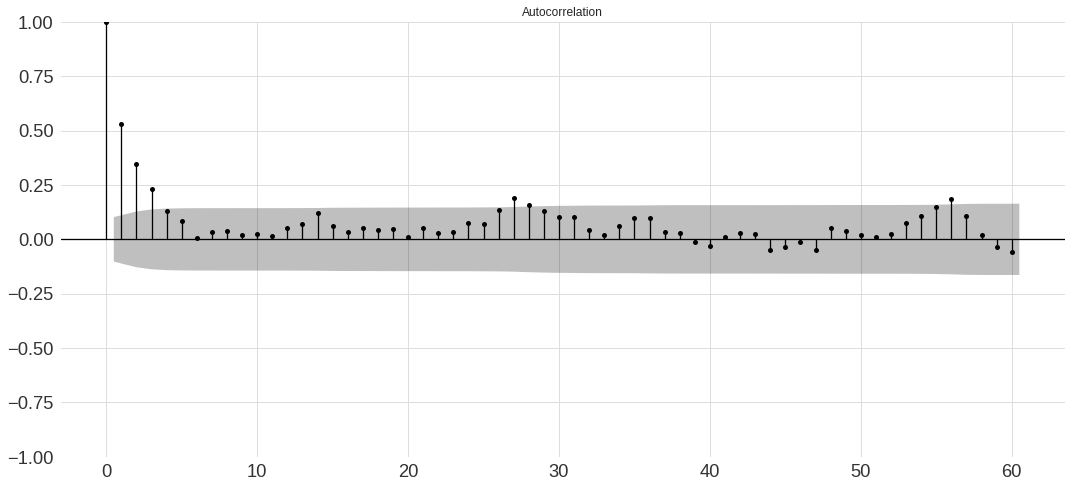

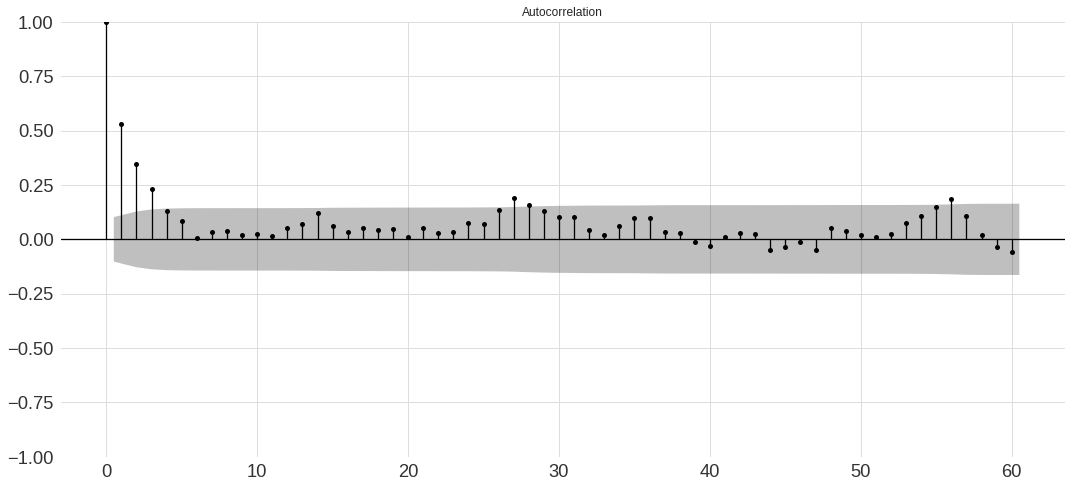

In [15]:
sm.graphics.tsa.plot_acf(get_input_item(item_id='HOUSEHOLD_1_459').sales,lags=60)

## Building prediction models

In [11]:
def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 1
    
    if future_covs == False:
        print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*1)]
    else:
        return res_df
    #return res_df

In [12]:
input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_586').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_252').set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])

input_train, _ = input_timeseries.split_before(0.33)

lgbm_model_cov = LightGBMModel(lags=[-1,-2,-52],
                                   lags_future_covariates=[0,1],
                                   boosting_type='gbdt', 
                                   num_leaves=20, 
                                   max_depth= -1, 
                                   learning_rate=0.1, 
                                   n_estimators=100)
    
lgbm_model_cov.fit(input_train,
                       future_covariates=future)

forecast_df = get_historical_forecasts(lgbm_model_cov,
                         input_timeseries=input_timeseries,
                         model_display_name = lgbm_model_cov,
                         future_covariates=future,
                         future_covs = True)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

5.251693377237294

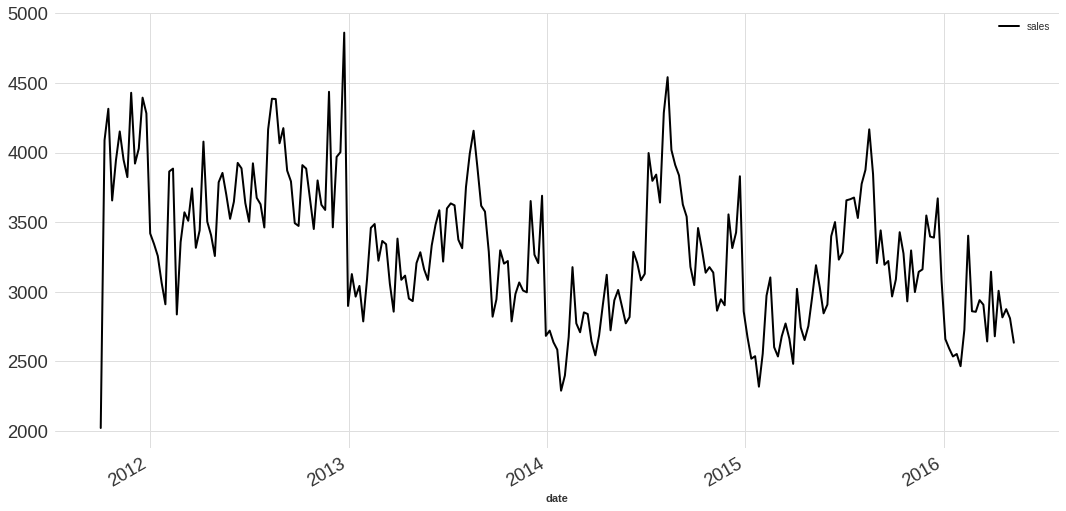

In [13]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.backtest(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.5, 
                                          retrain=retrain,
                                          verbose=True, 
                                          metric=mape,
                                          last_points_only=False,
                                          stride=6,
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries.plot()
    
    return backtest
    #print(str(model)+' Backtest MAPE = {}'.format(mape(input_timeseries, backtest)))



    
bt_errors = eval_model(lgbm_model_cov,
                         input_timeseries=input_timeseries,
                         future_covariates=future)

bt_errors

In [47]:
bt_errors

6.325652642878977

In [14]:
input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_252').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_252').set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])

input_train, _ = input_timeseries.split_before(0.33)


parameters = {'learning_rate': [0.1,0.01,0.001],
             'n_estimators': [100,300],
             'lags': [1,2,52],
              'num_leaves': [10,20,50],
              'max_depth':[-1,6,10]
             }

best_model = LightGBMModel.gridsearch(parameters=parameters,
                         series=input_timeseries,
                         forecast_horizon=1,
                         start=.5,
                         metric=mape,
                         reduction=np.mean)

[2022-07-08 21:21:06,698] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'learning_rate': 0.01, 'n_estimators': 300, 'lags': 52, 'num_leaves': 10, 'max_depth': 6}
[2022-07-08 21:21:06,698] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'learning_rate': 0.01, 'n_estimators': 300, 'lags': 52, 'num_leaves': 10, 'max_depth': 6}
INFO:darts.models.forecasting.forecasting_model:Chosen parameters: {'learning_rate': 0.01, 'n_estimators': 300, 'lags': 52, 'num_leaves': 10, 'max_depth': 6}


In [75]:
parameters = {'max_depth': [1,6,10],
             'n_estimators': [100,300],
             'lags': [1,2,52]}

best_model = RandomForest.gridsearch(parameters=parameters,
                         series=input_timeseries,
                         forecast_horizon=1,
                         start=.5,
                         metric=mape,
                         reduction=np.mean)

[2022-07-07 20:47:28,217] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'max_depth': 10, 'n_estimators': 100, 'lags': 52}
[2022-07-07 20:47:28,217] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'max_depth': 10, 'n_estimators': 100, 'lags': 52}
INFO:darts.models.forecasting.forecasting_model:Chosen parameters: {'max_depth': 10, 'n_estimators': 100, 'lags': 52}


In [17]:
input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_252').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_252').set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])

input_train, _ = input_timeseries.split_before(0.33)


parameters = {'p': [0,1,2,3],
             'd': [0,1],
             'q': [0,1,2],
             #'trend': ['n','c','t']
             }

best_model = ARIMA.gridsearch(parameters=parameters,
                         series=input_timeseries,
                         forecast_horizon=1,
                         start=.5,
                         metric=mape,
                         reduction=np.mean)

[2022-07-08 21:49:34,346] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 3, 'd': 0, 'q': 2}
[2022-07-08 21:49:34,346] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'p': 3, 'd': 0, 'q': 2}
INFO:darts.models.forecasting.forecasting_model:Chosen parameters: {'p': 3, 'd': 0, 'q': 2}
